In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# 定义转换操作
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.Resize((256, 256)),  # 注意：MNIST图像是28x28，这里需要调整大小到256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # MNIST是灰度图像，所以只有一个通道
])

# 加载MNIST数据集
def load_data():
    print('data processing...')
    # 下载并加载训练数据
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    
    # 下载并加载测试数据
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # 划分训练数据为训练集和验证集
    train_size = int(len(train_dataset) * 0.8)
    validate_size = len(train_dataset) - train_size
    train, val = random_split(train_dataset, [train_size, validate_size])

    # 创建数据加载器
    train_data_loader = DataLoader(dataset=train, batch_size=50, shuffle=True, num_workers=0)
    val_data_loader = DataLoader(dataset=val, batch_size=50, shuffle=True, num_workers=0)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=0)

    return train_data_loader, val_data_loader, test_data_loader

# 调用函数以加载数据
train_data_loader, val_data_loader, test_data_loader = load_data()

data processing...
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [16:01<00:00, 10.3kB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 36.0kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [05:24<00:00, 5.09kB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 17.6kB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def setup_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


setup_seed(20)

class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # 调整全连接层输入大小
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.out = nn.Linear(10, 10)  # 输出层不需要Softmax

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.out(x))
        return x

def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)
    return train_data_loader, None, test_data_loader

def get_val_loss(model, Val):
    model.eval()
    criterion = nn.CrossEntropyLoss().to(device)
    val_loss = []
    for (data, target) in Val:
        data, target = data.to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss.append(loss.cpu().item())
    return np.mean(val_loss)

import time

def metric_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} took {end_time - start_time:.4f} seconds to execute")
        return result
    return wrapper

@metric_time
def train():
    writer = SummaryWriter("log/")
    train_data_loader, _, test_data_loader = load_data()
    print('train...')
    epoch_num = 30
    best_model = None
    min_epochs = 5
    min_val_loss = np.inf
    model = cnn().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0008)
    criterion = nn.CrossEntropyLoss().to(device)
    for epoch in tqdm(range(epoch_num), ascii=True):
        train_loss = []
        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = data.to(device), target.long().to(device)
            model.train()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.cpu().item())
        # validation
        val_loss = get_val_loss(model, train_data_loader)  # 使用训练数据作为验证数据
        writer.add_scalar("val_loss", val_loss, epoch)
        if epoch + 1 > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        tqdm.write('Epoch {:03d} train_loss {:.5f} val_loss {:.5f}'.format(epoch, np.mean(train_loss), val_loss))

    # 确保模型保存路径的父目录存在
    model_dir = "model"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    torch.save(best_model.state_dict(), "model/cnn_mnist.pkl")

@metric_time
def test():
    _, _, test_data_loader = load_data()
    model = cnn().to(device)
    model.load_state_dict(torch.load("model/cnn_mnist.pkl"), False)
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for (data, target) in test_data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print('Accuracy:%d%%' % (100 * correct / total))

# 调用训练和测试函数
train()
test()

train...


  3%|##7                                                                                | 1/30 [00:37<18:08, 37.55s/it]

Epoch 000 train_loss 1.70107 val_loss 1.66778


  7%|#####5                                                                             | 2/30 [01:15<17:32, 37.58s/it]

Epoch 001 train_loss 1.66698 val_loss 1.66287


 10%|########3                                                                          | 3/30 [01:52<16:56, 37.63s/it]

Epoch 002 train_loss 1.66219 val_loss 1.65943


 13%|###########                                                                        | 4/30 [02:31<16:31, 38.12s/it]

Epoch 003 train_loss 1.65922 val_loss 1.65707


 17%|#############8                                                                     | 5/30 [03:10<16:01, 38.45s/it]

Epoch 004 train_loss 1.65696 val_loss 1.65503


 20%|################6                                                                  | 6/30 [03:49<15:29, 38.71s/it]

Epoch 005 train_loss 1.58197 val_loss 1.56769


 23%|###################3                                                               | 7/30 [04:29<14:53, 38.85s/it]

Epoch 006 train_loss 1.56530 val_loss 1.56425


 27%|######################1                                                            | 8/30 [05:08<14:16, 38.92s/it]

Epoch 007 train_loss 1.56340 val_loss 1.56191


 30%|########################9                                                          | 9/30 [05:46<13:34, 38.79s/it]

Epoch 008 train_loss 1.49138 val_loss 1.46999


 33%|###########################3                                                      | 10/30 [06:25<12:55, 38.77s/it]

Epoch 009 train_loss 1.47082 val_loss 1.47220


 37%|##############################                                                    | 11/30 [07:04<12:17, 38.83s/it]

Epoch 010 train_loss 1.46983 val_loss 1.46894


 40%|################################8                                                 | 12/30 [07:43<11:38, 38.81s/it]

Epoch 011 train_loss 1.46925 val_loss 1.46693


 43%|###################################5                                              | 13/30 [08:22<11:00, 38.84s/it]

Epoch 012 train_loss 1.46810 val_loss 1.46667


 47%|######################################2                                           | 14/30 [09:00<10:19, 38.71s/it]

Epoch 013 train_loss 1.46803 val_loss 1.46733


 50%|#########################################                                         | 15/30 [09:39<09:41, 38.77s/it]

Epoch 014 train_loss 1.46767 val_loss 1.46566


 53%|###########################################7                                      | 16/30 [10:18<09:04, 38.86s/it]

Epoch 015 train_loss 1.46702 val_loss 1.46614


 57%|##############################################4                                   | 17/30 [10:57<08:27, 39.03s/it]

Epoch 016 train_loss 1.46730 val_loss 1.46728


 60%|#################################################1                                | 18/30 [11:36<07:47, 38.97s/it]

Epoch 017 train_loss 1.46681 val_loss 1.46689


 63%|###################################################9                              | 19/30 [12:15<07:08, 38.96s/it]

Epoch 018 train_loss 1.46639 val_loss 1.46568


 67%|######################################################6                           | 20/30 [12:54<06:29, 38.97s/it]

Epoch 019 train_loss 1.46627 val_loss 1.46487


 70%|#########################################################4                        | 21/30 [13:33<05:50, 38.94s/it]

Epoch 020 train_loss 1.46641 val_loss 1.46543


 73%|############################################################1                     | 22/30 [14:13<05:13, 39.13s/it]

Epoch 021 train_loss 1.46607 val_loss 1.46469


 77%|##############################################################8                   | 23/30 [14:52<04:34, 39.15s/it]

Epoch 022 train_loss 1.46586 val_loss 1.46478


 80%|#################################################################6                | 24/30 [15:31<03:55, 39.18s/it]

Epoch 023 train_loss 1.46518 val_loss 1.46406


 83%|####################################################################3             | 25/30 [16:11<03:16, 39.30s/it]

Epoch 024 train_loss 1.46514 val_loss 1.46630


 87%|#######################################################################           | 26/30 [16:50<02:37, 39.39s/it]

Epoch 025 train_loss 1.46558 val_loss 1.46479


 90%|#########################################################################8        | 27/30 [17:30<01:58, 39.36s/it]

Epoch 026 train_loss 1.46524 val_loss 1.46726


 93%|############################################################################5     | 28/30 [18:09<01:18, 39.36s/it]

Epoch 027 train_loss 1.46513 val_loss 1.46427


 97%|###############################################################################2  | 29/30 [18:48<00:39, 39.38s/it]

Epoch 028 train_loss 1.46479 val_loss 1.46347


100%|##################################################################################| 30/30 [19:28<00:00, 38.94s/it]
C:\Users\admin\AppData\Local\Temp/ipykernel_10724/3770768901.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on 

Epoch 029 train_loss 1.46442 val_loss 1.46518
train took 1168.2078 seconds to execute
Accuracy:99%
test took 2.5026 seconds to execute


Predicted label: 0
Class probabilities: tensor([[0.1021, 0.0996, 0.1002, 0.1002, 0.0995, 0.0977, 0.0984, 0.1014, 0.1012,
         0.0997]])


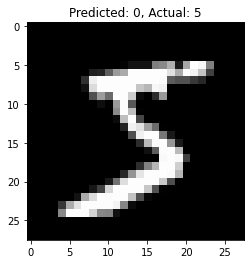

In [51]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# 假设model已经定义并加载了权重
model.eval()

_img_path = r"C:\Users\admin\Desktop\DataImages-Train\0-label-5.png"
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

img = Image.open(_img_path).convert('L')
img_transform = transform(img).unsqueeze(0)

with torch.no_grad():
    output = model(img_transform)

# 获取预测类别和置信度
_, predicted = torch.max(output, 1)
probabilities = torch.nn.functional.softmax(output, dim=1)

print(f"Predicted label: {predicted.item()}")
print(f"Class probabilities: {probabilities}")

# 显示图像
plt.imshow(img.convert('L'), cmap='gray')
plt.title(f'Predicted: {predicted.item()}, Actual: {label}')
plt.show()